In [1]:
import sys
sys.path.append('..')

from torch.utils.data import Dataset
import torch
import numpy as np
import os
from PIL import Image
import cv2
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

from utils import *
from scripts import *

%load_ext autoreload
%autoreload 2

In [2]:
class Self_CollectedDS(Dataset):
    def __init__(self, root_dir, split='train', shuffle=False, img_num=1, visible_img=1, focus_dist=[0.89, 1.06, 1.4, 1.94, 2.37], recon_all=True, 
                    RGBFD=True, scale=10, near=0.1, far=5.):
        self.root_dir = root_dir
        self.shuffle = shuffle
        self.img_num = img_num
        self.visible_img = visible_img
        self.focus_dist = torch.Tensor(focus_dist)
        self.recon_all = recon_all
        self.RGBFD = RGBFD
        self.scale = scale
        self.near = near
        self.far = far

        self.all_path = self.root_dir

        ##### Load and sort all images
        self.imglist_all = [f for f in os.listdir(self.all_path) if os.path.isfile(os.path.join(self.all_path, f)) and f[-4:]=='.JPG']

        self.n_stack = len(self.imglist_all) // self.img_num
        if split == 'train':
            print(f"{self.visible_img} out of {self.img_num} images per sample are visible for input")
        self.imglist_all.sort()

    def __len__(self):
        return self.n_stack

    def __getitem__(self, idx):
        img_idx = idx * self.img_num

        sub_idx = np.arange(self.img_num)
        if self.shuffle:
            np.random.shuffle(sub_idx)
        input_idx = sub_idx[:self.visible_img]
        if self.recon_all:
            output_idx = sub_idx
        else:
            output_idx = sub_idx[self.visible_img:]

        mats_input = []
        mats_output = []

        for i in sub_idx:
            mat_all = Image.open(os.path.join(self.all_path, self.imglist_all[i]))
            mat_all = np.asarray(mat_all, dtype=np.float32) / 255.
            H, W, C = mat_all.shape
            # mat_all = cv2.resize(mat_all, (W//self.scale, H//self.scale))
            if i in output_idx:    
                mats_output.append(torch.from_numpy(mat_all.transpose((2, 0, 1))).unsqueeze(0))
            if self.RGBFD and i in input_idx:   
                mat_fd = self.focus_dist[i].view(-1, 1, 1).expand(*mat_all.shape[:-1], 1).numpy()
                mat_all = np.concatenate([mat_all, mat_fd], axis=-1)                 
                mats_input.append(torch.from_numpy(mat_all.transpose((2, 0, 1))).unsqueeze(0))

        data = dict(output=torch.cat(mats_output), output_fd=self.focus_dist[output_idx])

        if self.RGBFD:
            data.update(rgb_fd = torch.cat(mats_input))

        return data

In [3]:
data_path = '/mnt/cfs/sihaozhe/data/sc-ds/07'
split = 'train'
device = 0
use_cuda = True

In [4]:
ds = Self_CollectedDS(data_path, img_num=5, visible_img=5)

5 out of 5 images per sample are visible for input


In [5]:
H, W, C = ds[0]['output'][4].numpy().transpose(1, 2, 0).shape
H, W

(3648, 5472)

In [6]:
# ds[0]['output']


In [16]:
base_img = ds[0]['output'][0].numpy().transpose(1, 2, 0)
sel_hs = []
sel_h = 20
for i in range(1, 5):
    prev_mse = np.inf
    for h in trange (sel_h, 150, 5):
        w = int(h/3*2)
        aligned_img = cv2.resize(ds[0]['output'][i].numpy().transpose(1, 2, 0)[w:-w, h:-h], (W, H))
        mse = ((aligned_img - base_img)**2).mean()
        if mse < prev_mse:
            prev_mse = mse
        else:
            sel_h = h - 5
            sel_hs.append(sel_h)
            sel_w = int(sel_h/3*2)
            base_img = cv2.resize(ds[0]['output'][i].numpy().transpose(1, 2, 0)[sel_w:-sel_w, sel_h:-sel_h], (W, H))
            break

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
sel_hs

[45, 70, 130, 130]

In [18]:
h = 50
w = int(h/3*2)
h, w

(50, 33)

In [117]:
aligned_img = cv2.resize(ds[0]['output'][1].numpy().transpose(1, 2, 0)[w:-w, h:-h], (W, H))

In [118]:
((aligned_img - base_img)**2).mean()

0.0017708967

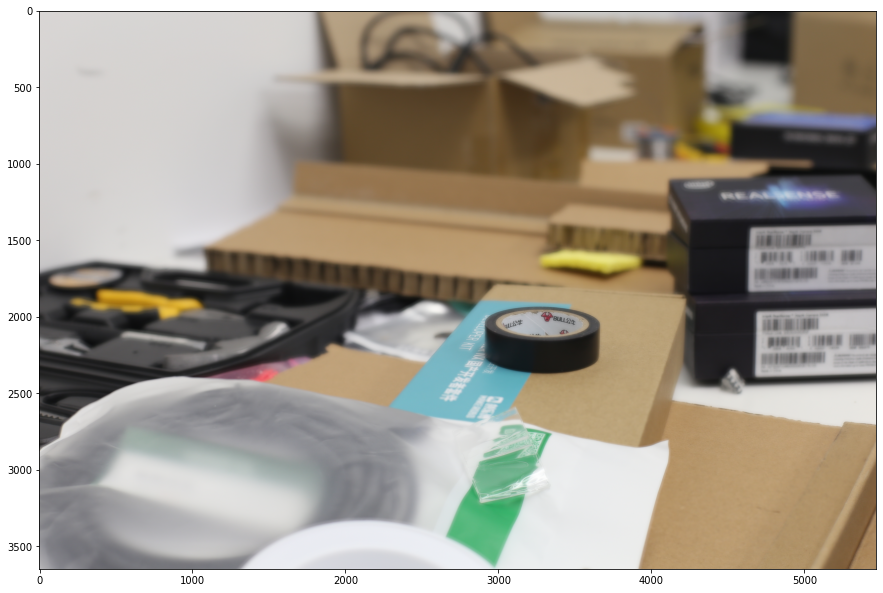

In [120]:
plt.figure(figsize=(15, 20))
plt.imshow(base_img*0.5 + aligned_img*0.5)


In [115]:
72/3*2

48.0